# Margin Cache Affine Tranform

for hipscat-import, we want to be able to build up a suitable bounding box to check potential `neighbors.parquet` data points against.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import healpy as hp
import numpy as np
from astropy import units as u

%matplotlib inline

## The Problem

Healpix is really good at determing what points are in a specific pixel, but if we want to isolate an individual pixel and figure out what points might be near it, the problem becomes much harder.

Healpix works by creating a bunch of **non-geodesic** lines around the sphere and simply checking if the points are between 4 different lines that make up the boundaries of an individual healpix pixel. Great for determining which pixel an individual datapoint is in quickly, not so great when we want to figure out what points are *not* in the given pixel but are near it. This causes us issues when we want the find points that are withing a `margin_threshold` of a given pixel to store in our `neighbors.parquet` fiels for caching purposes. Since there's no easy way for us to grab/reconstruct the sides of a healpix pixel, we can use a healpy utility function to get a sample of points along the pixel edges and build a bounding box ourselves.

let's take a look at the results we get from the `healpy.boundaries` method, which returns points along the boundaries of a given pixel at a given order.

[[-45.         -67.5        -45.         -22.5       ]
 [ 41.8103149   19.47122063   0.          19.47122063]]


(-5.0, 50.0)

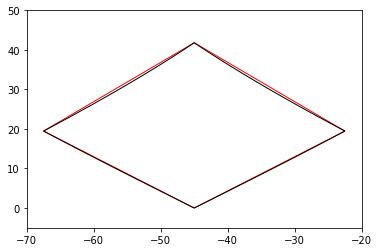

In [2]:
ax = plt.subplot(1, 1, 1)

# step == 1, just the corners of the pixel. (red)
# step == 100, we get a sample of 100 points along each side of the pixel. (black)
for step, color in [(1, 'red'), (100, 'black')]:
    coords = hp.vec2dir(hp.boundaries(2, 12, step=step, nest=True), lonlat=True)
    if step == 1:
        print(coords)
    lon = coords[0]
    lat = coords[1]
    vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
    p = Polygon(vertices, closed=True, edgecolor=color, facecolor='none')
    ax.add_patch(p)
    
plt.xlim(-70, -20)
plt.ylim(-5, 50)

As you can see, the polygon in black (with 400 sampled points) much more closely represents the actual shape of the pixel, with irregular curvilinear boundaries. The pixels also vary greatly in shape at different latitudes and longitudes. (the given pixel, order 1 pixel 12, has a relatively high latitude, giving it it's oblong shape).

## Margin Checking
Now that we know we can get a decent approximation of the shape, we can focus on another difficult problem: how to actually determine the boundaries that we want to check data points against for the margin cache.

Since a healpix pixel has an irregular shape, and is curvilinear, it isn't as simple as just adding the `margin_threshold` to the corners of our bounding box. The shape of a pixel is too irregular, and besides it would be unwiedly for us to find the actual length of each side since we're only building a polygon out of sampled points along the pixel boundary. We do have one thing going for, though: each pixel at a given order `k` has the same area! This means we can get the squareroot of a given pixel area (healpix refers to this as the pixel `resolution`), add the `margin_threshold` to it twice (representing adding a a margin on both sides), and then square that again to get what the area of our bounding box should be.

From there, we divide this pixel + threshold area by the original pixel area to find the scale factor, and just create an affine transform to scale the original bounding box to encompass the margin region.

(-5.0, 50.0)

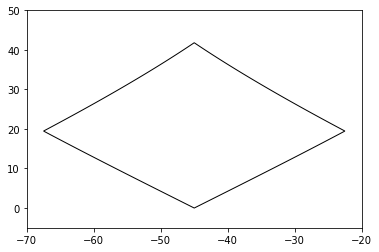

In [3]:
# let's build a new bounding box of our pixel to work on.
ax2 = plt.subplot(1, 1, 1)
step = 100
original_bounding_box = hp.vec2dir(hp.boundaries(2, 12, step=step, nest=True), lonlat=True)

lon = original_bounding_box[0]
lat = original_bounding_box[1]
vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
p = Polygon(vertices, closed=True, edgecolor=color, facecolor='none')
ax2.add_patch(p)

plt.xlim(-70, -20)
plt.ylim(-5, 50)

Now let's find the scale and make a new bounding box!

In [4]:
margin_threshold = 1. # in degrees
resolution = hp.pixelfunc.nside2resol(2, arcmin=True) / 60. # in degrees
new_res = resolution + (2 * margin_threshold)
margin_area = new_res ** 2
pixel_area = hp.pixelfunc.nside2pixarea(2, degrees=True)
scale = margin_area / pixel_area
scale, margin_area, pixel_area

(1.1410977723981837, 980.7012955529358, 859.4366926962348)

(-5.0, 50.0)

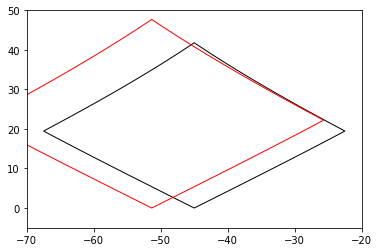

In [5]:
# before we do the scaling, we should transfer our original bounding box into homogenous coordinates 
# (needed for an affine transform)
homogeneous = np.ones((3, original_bounding_box.shape[-1]))
homogeneous[0] = original_bounding_box[0]
homogeneous[1] = original_bounding_box[1]

# now we can build up our affine transform matrix!
scale_matrix = np.array([[scale, 0, 0],
                         [0, scale, 0],
                         [0,     0, 1]])

# and voila, we can scale our bounding box and get the coordinates!
margin_bounding_box = np.matmul(scale_matrix, homogeneous)

ax3 = plt.subplot(1, 1, 1)
for points, color in zip([original_bounding_box, margin_bounding_box], ['black', 'red']):
    lon = points[0]
    lat = points[1]
    vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
    p = Polygon(vertices, closed=True, edgecolor=color, facecolor='none')
    ax3.add_patch(p)
plt.xlim(-70, -20)
plt.ylim(-5, 50) 

uh oh!!!! Our new bounding box isn't centered around the original pixel! This is because the affine transform scales from the origin of our coordinate system, i.e. (0,0). To actually have it scale around the center, we need to work with the centroid.

## The Centroid
To accurately create our bounding box, we need to find the centroid of our original shape. From there, we can run that point through our scalar transform, find the difference between the new point and our original centroid, and then transform the new bounding box back over the original center. The result should give us a nicely scaled box that includes a border region approximately one `margin_threshold` away from the actual healpix pixel!

In [6]:
# first, let's grab the x and y coordinates (or lon and lat, doesn't really matter, does it?).
# we can do this by finding the average for each variable.
n_points = len(original_bounding_box[0])
x = np.sum(original_bounding_box[0]) / n_points
y = np.sum(original_bounding_box[1]) / n_points

# centroid in homogeneous coordinates
centroid = np.array([x, y, 1])
centroid

array([-45.        ,  19.92530172,   1.        ])

In [7]:
# now let's scale
scaled_centroid = np.matmul(scale_matrix, centroid)
scaled_centroid

array([-51.34939976,  22.73671741,   1.        ])

(-5.0, 50.0)

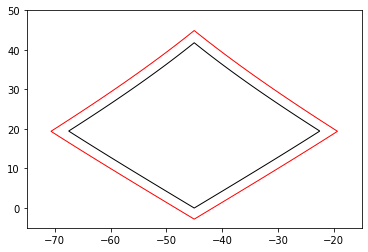

In [8]:
# looks about like what we would expect, given how the rest of the points were translated.
# now we can grab the differences between the two points and add a translation to the scaling matrix!
x_trans = centroid[0] - scaled_centroid[0]
y_trans = centroid[1] - scaled_centroid[1]

transform_matrix = np.array([[1, 0, x_trans],
                             [0, 1, y_trans],
                             [0, 0,       1]])

# now let's do the affine transformation again and see what we get.
margin_bounding_box2 = np.matmul(transform_matrix, margin_bounding_box)

ax4 = plt.subplot(1, 1, 1)
for points, color in zip([original_bounding_box, margin_bounding_box2], ['black', 'red']):
    lon = points[0]
    lat = points[1]
    vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
    p = Polygon(vertices, closed=True, edgecolor=color, facecolor='none')
    ax4.add_patch(p)
plt.xlim(-75, -15)
plt.ylim(-5, 50) 

Success!!!

## Things I've Learned
- Affine transforms are really cool
    - why didn't I pay close attention to them in linear algebra??
- Healpix is somewhat complicated to work with, but once you get a hang of the underlying geometric principles of the system everything starts to make sense.
- Numpy makes everything easier.
- This affine transform shouldn't be too hard to work into our currently working prototype of margin caching on LSD2 and should be a breeze to to implement in hipscat/hipscat-import.

## Questions I Still Have
- Does the math here make sense?
    - I'm specifically curious about my method for determining the proper scale for this tranform. It intiutively makes sense to me to use the resolution as essentially the "side length" of a healpix pixel and that comparing the area between the original and the resolution + (2 * threshold), and the results here seem to show that it works, but I'm not totally sure the math all adds up.
        - of course, all of this is about approximation anyway, and this approximation looks good, so ¯\\_(ツ)_\/¯
- Is there a more efficient way of doing this?
    - Numpy's matrix multiplication is simple and seems to work really fast, but maybe there's an even better way of doing these transforms that someone knows about. If you do, please let me know!
    
If you're interested in reading up on how healpix works mathematically, you can do that [here](https://healpix.jpl.nasa.gov/html/intronode4.htm).

If you would like to see the prototype of the broader margin caching algorithm, you can look at our hipscat prototype [LSD2](https://github.com/astronomy-commons/lsd2).

You can also check out our more refined (and still a work in progress) version of the hipscat ecosystem at the following places:
- [hipscat](https://github.com/astronomy-commons/hipscat)
- [hipscat-import](https://github.com/astronomy-commons/hipscat-import/)
- [lsdb](https://github.com/astronomy-commons/lsdb) (note: empty as the writing of this notebook).